In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
import tensorflow as tf
import math
import geopandas as gpd
from shapely.geometry import Point
from shapely.strtree import STRtree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import statsmodels.api as sm
import keras_tuner as kt
import os
!pip install scikeras
from scikeras.wrappers import KerasRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 20.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
# Import data

data = pd.read_csv('/kaggle/input/aqbench-dataset/AQbench_dataset.csv')
data = pd.DataFrame(data)
data.shape

(5577, 53)

In [3]:
# Count the amount of zeros in features

count_per_column = (data == 0).sum()
print(count_per_column)

id                                            0
country                                       0
htap_region                                   0
climatic_zone                                 0
lon                                           0
lat                                           0
alt                                         184
relative_alt                                262
type                                          0
type_of_area                                  0
water_25km                                 2976
evergreen_needleleaf_forest_25km           3679
evergreen_broadleaf_forest_25km            5356
deciduous_needleleaf_forest_25km           5571
deciduous_broadleaf_forest_25km            4197
mixed_forest_25km                          1357
closed_shrublands_25km                     5194
open_shrublands_25km                       4854
woody_savannas_25km                        2986
savannas_25km                              5264
grasslands_25km                         

/tmp/ipykernel_30/3055831822.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


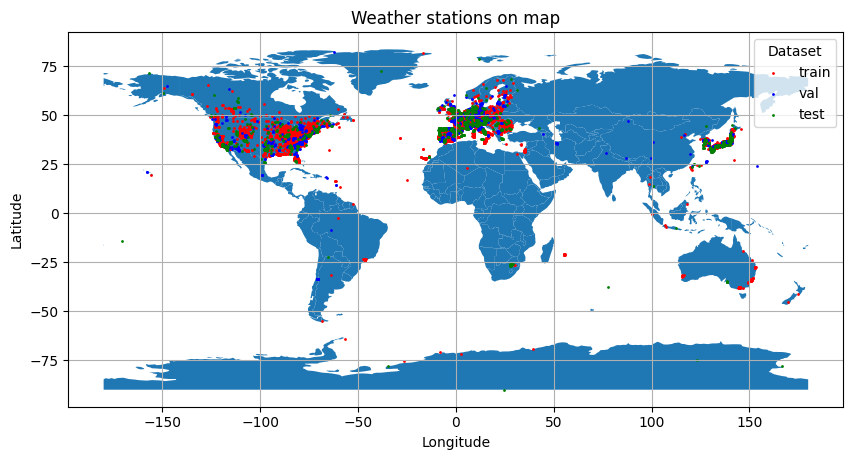

In [4]:
# Plot weather staions on map

colors = {'train': 'red', 'val': 'blue', 'test': 'green'}

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(10, 6))

for dataset_type, color in colors.items():
    subset = data[data['dataset'] == dataset_type]
    plt.scatter(subset['lon'], subset['lat'], c=color, label=dataset_type, s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Weather stations on map')
plt.legend(title="Dataset")
plt.grid(True)

plt.show()

In [5]:
# Define different type of columns

columns_cyclical=['lon']
columns_categorical=['country', 'htap_region', 'climatic_zone', 'type', 'type_of_area']
columns_help=['id', 'dataset']
columns_target=['o3_average_values', 'o3_daytime_avg', 'o3_nighttime_avg', 'o3_median', 'o3_perc25', 'o3_perc75', 'o3_perc90', 'o3_perc98', 'o3_dma8eu', 'o3_avgdma8epax', 'o3_drmdmax1h', 'o3_w90', 'o3_aot40', 'o3_nvgt070', 'o3_nvgt100']

In [6]:
# Clean data by removing ore replacing missing values
# Replacing values takes a long time, thats why i provided a csv where the data has been cleand locally with the replace_missing_data function

def drop_missing_data(data):
    return data.replace(-999, np.nan).dropna()

def replace_missing_data(data, max_distance_km=25):
    data.replace(-999, np.nan, inplace=True)
    rows_to_drop = []

    for index, row in data.iterrows():
        if row.isnull().any():
            coordinates = (row['lat'], row['lon'])
            distances = []

            for i, potential_neighbor in data.drop(index).iterrows():
                neighbor_coords = (potential_neighbor['lat'], potential_neighbor['lon'])

                if not potential_neighbor.isnull().any():
                    distance = geodesic(coordinates, neighbor_coords).kilometers
                    if distance <= max_distance_km:
                        distances.append((i, distance))

            if distances:
                nearest_station_index, _ = min(distances, key=lambda x: x[1])
                nearest_station_values = data.loc[nearest_station_index]

                for col in data.columns:
                    if pd.isna(row[col]) and not pd.isna(nearest_station_values[col]):
                        data.at[index, col] = nearest_station_values[col]
            else:
                rows_to_drop.append(index)

    data.drop(index=rows_to_drop, inplace=True)
    return data

# deprecated approach
# data = drop_missing_data(data)

# this might take a long time
# data = replace_missing_data(data)

# prepared cleaned data
data = pd.read_csv('/kaggle/input/cleaned-aqbench/cleaned_AQbench_dataset.csv')

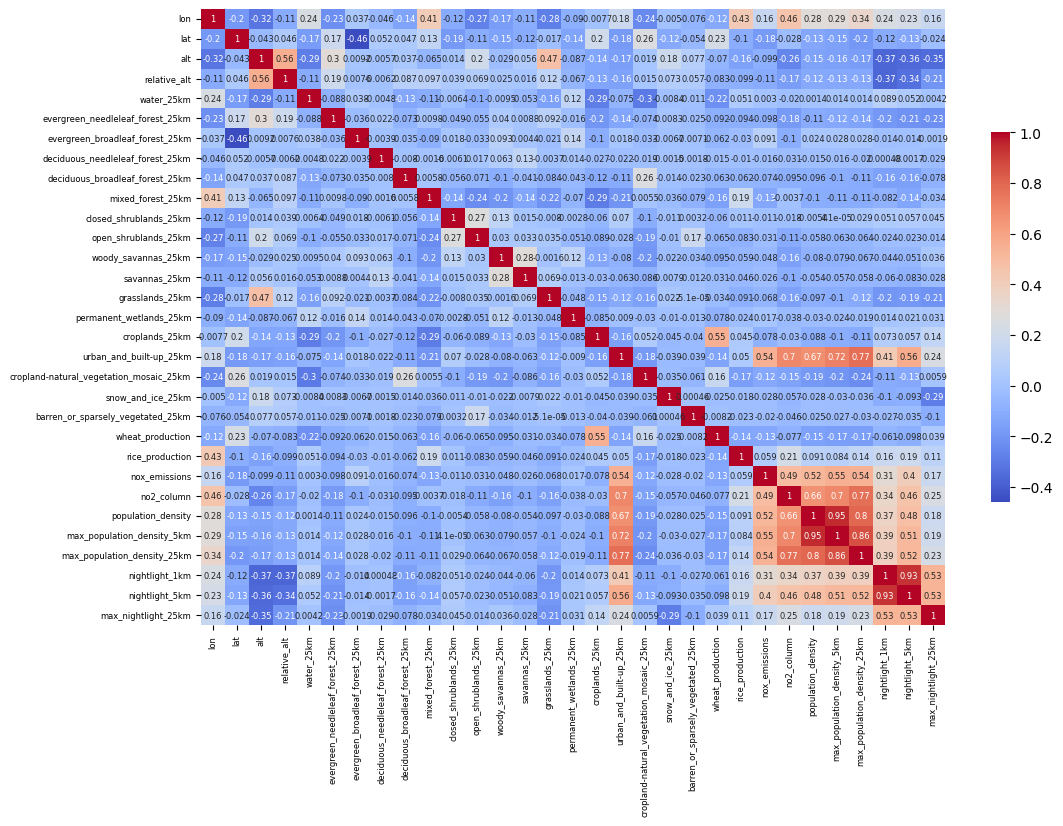

In [7]:
# Corralation matrix for feature analysis

data_input = data.drop(columns=columns_target, axis=1)
data_input = data_input.drop(columns=columns_help, axis=1)
data_input = data_input.drop(columns=columns_categorical, axis=1)

corr_matrix = data_input.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6}, cbar_kws={"shrink": 0.6})
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.show()

In [8]:
# Remove features with high correlation

columns_correlated = ['max_population_density_25km', 'population_density', 'nightlight_1km']

data = data.drop(columns=columns_correlated, axis=1)

print(data.shape)

(5071, 50)


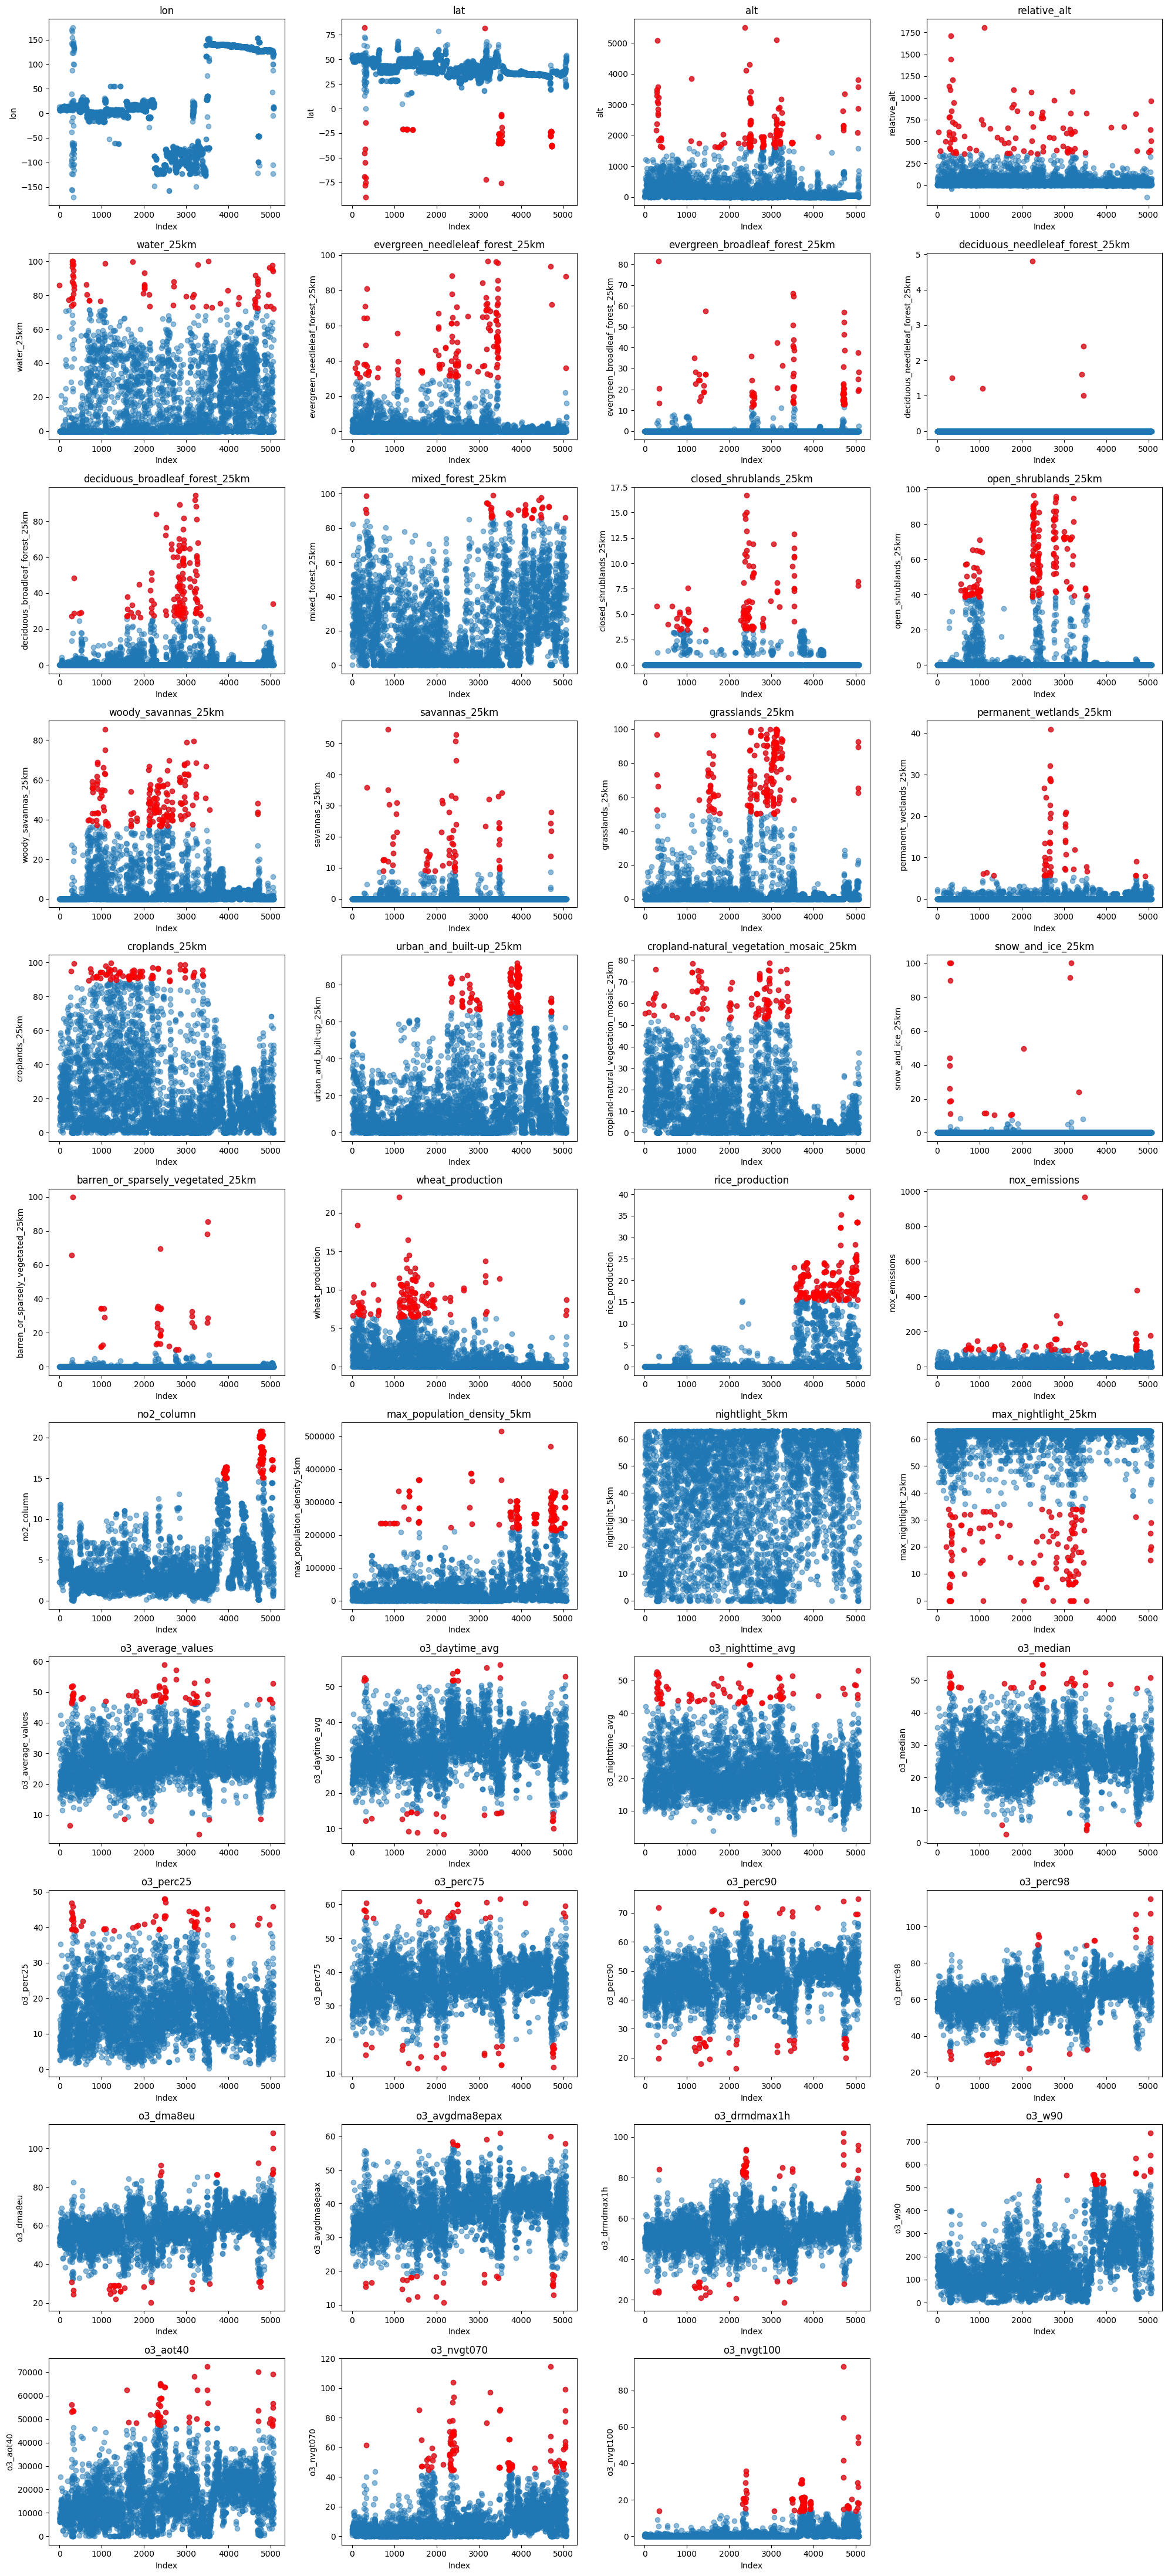

Amount of indices with outliers in 5 or more columns: 111


In [9]:
# Outliers analysis for all continous and cyclical features

data_continous = data.drop(columns=columns_categorical, axis=1)
data_continous = data_continous.drop(columns=columns_help, axis=1)
numerical_columns = data_continous.columns

outlier_counts = pd.Series(0, index=data_continous.index)

num_vars = len(numerical_columns)
num_cols = 4
num_rows = math.ceil(num_vars / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    mean = data_continous[col].mean()
    std = data_continous[col].std()
    threshold_upper = mean + 3 * std
    threshold_lower = mean - 3 * std
    outliers = data_continous[(data_continous[col] > threshold_upper) | (data_continous[col] < threshold_lower)]
    outlier_counts.loc[outliers.index] += 1
    axes[i].scatter(data_continous.index, data_continous[col], alpha=0.5)
    axes[i].scatter(outliers.index, outliers[col], color='red', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(col)
    min_val = data_continous[col].min()
    if min_val > 0 and (data_continous[col].max() / min_val) > 1000:
        axes[i].set_yscale('log')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

outlier_indices = outlier_counts[outlier_counts >= 5].index.tolist()
outlier_indices = sorted(outlier_indices)

print("Amount of indices with outliers in 5 or more columns:", len(outlier_indices))

In [10]:
# Remove smaples that posess 5 or more outliers

print(data.shape)
data = data.drop(index=outlier_indices).reset_index(drop=True)
print(data.shape)

(5071, 50)
(4960, 50)


In [11]:
# deprecated

# Adding the distcance to the next ocean feature
# This takes a long time in kaggle so i provieded a dataset where this is done on my pc

def calc_dist_ocean(data):
    geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
    gdata = gpd.GeoDataFrame(data, geometry=geometry)
    gdata.set_crs(epsg=4326, inplace=True)

    coastlines = gpd.read_file('/kaggle/input/data-costline/ne_10m_coastline.shp')
    coastlines.set_crs(epsg=4326, inplace=True)

    gdata = gdata.to_crs(epsg=3857)
    coastlines = coastlines.to_crs(epsg=3857)

    gdata['distance_to_ocean'] = gdata.geometry.apply(lambda point: coastlines.distance(point).min())

    return gdata.to_crs(epsg=4326).drop(columns='geometry')

# This might take a long time
#data = calc_dist_ocean(data)

# Prepared dataset which includes the distances
# data = pd.read_csv("/kaggle/input/dataset-ocean-distance/data_dist_ocean.csv")

In [12]:
# Group different colums with simialar attributes

grouped_columns = {
    "forest": ['evergreen_needleleaf_forest_25km', 'evergreen_broadleaf_forest_25km', 'deciduous_needleleaf_forest_25km', 'deciduous_broadleaf_forest_25km', 'mixed_forest_25km'],
    "shrublands_savannas": ['closed_shrublands_25km', 'open_shrublands_25km', 'woody_savannas_25km', 'savannas_25km'],
    "grasslands_wetlands": ['grasslands_25km', 'permanent_wetlands_25km']
}

for group, cols in grouped_columns.items():
    data[group] = data[cols].mean(axis=1)

columns_to_drop = [col for cols in grouped_columns.values() for col in cols]
data = data.drop(columns=columns_to_drop)

print(data.shape)

(4960, 42)


In [13]:
# Calculate annual average GHI exposure for an indication of sun radiation

# !pip install pvlib
# import pvlib

def calculate_annual_solar_radiation(row):
    
    times = pd.date_range('2010-01-01', '2014-12-31', freq='h', tz='UTC')

    lat = row['lat']
    lon = row['lon']
    alt = row['alt']

    solpos = pvlib.solarposition.get_solarposition(times, lat, lon, alt)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(alt)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)

    cs = pvlib.clearsky.ineichen(
        solpos['apparent_zenith'],
        am_abs,
        linke_turbidity,
        altitude=alt,
        dni_extra=dni_extra
    )

    ghi = cs['ghi']

    return ghi.mean()

# This might take a long time
# data['annual_solar_radiation'] = data.apply(calculate_annual_solar_radiation, axis=1)

# Prepared dataset which includes sunlight exposure
data = pd.read_csv("/kaggle/input/data-sunlight/data_with_sunlight.csv")

print(data[['id', 'annual_solar_radiation']])

         id  annual_solar_radiation
0      3336              173.882754
1      3338              171.217084
2      3339              175.280377
3      3340              173.299764
4      3341              176.398407
...     ...                     ...
4955  17685              180.816222
4956  17718              172.354324
4957  17719              173.930308
4958  17720              191.676915
4959  17722              170.494962

[4960 rows x 2 columns]


In [14]:
# Created different features based on estimated VOCs and NOx emissions

data['estimated_biogenic_vocs'] = data[['forest', 'shrublands_savannas', 'grasslands_wetlands']].mean(axis=1)
data['estimated_anthropogenic_vocs'] = data[['urban_and_built-up_25km', 'nightlight_5km', 'croplands_25km']].mean(axis=1)
data['estimated_total_vocs'] = data['estimated_biogenic_vocs'] + data['estimated_anthropogenic_vocs']

data['nox_emissions'] = data['nox_emissions'].replace(0, np.nan)
data['nox_emissions'] = data['nox_emissions'].fillna(data['nox_emissions'].mean())

data['voc_nox_ratio'] = data['estimated_total_vocs'] / data['nox_emissions']
data['voc_nox_ratio'] = data['voc_nox_ratio'].replace([np.inf, -np.inf], np.nan)
data['voc_nox_ratio'] = data['voc_nox_ratio'].fillna(data['voc_nox_ratio'].mean())

data['nox_voc_interaction'] = data['nox_emissions'] * data['estimated_total_vocs']

data['nox_emissions'] = data['nox_emissions'].clip(lower=0)
data['estimated_total_vocs'] = data['estimated_total_vocs'].clip(lower=0)

data['log_nox_emissions'] = np.log1p(data['nox_emissions'])
data['log_estimated_voc_emissions'] = np.log1p(data['estimated_total_vocs'])

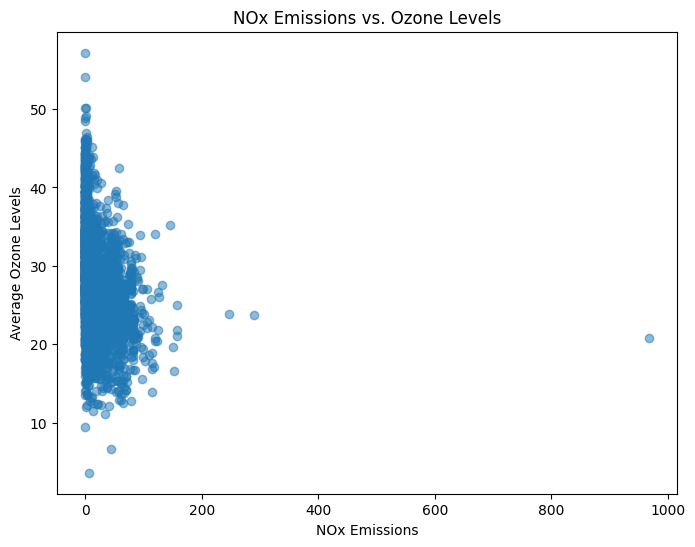

In [15]:
# Plot NOx emissions in realtion to average ozone levels

plt.figure(figsize=(8,6))
plt.scatter(data['nox_emissions'], data['o3_average_values'], alpha=0.5)
plt.xlabel('NOx Emissions')
plt.ylabel('Average Ozone Levels')
plt.title('NOx Emissions vs. Ozone Levels')
plt.show()

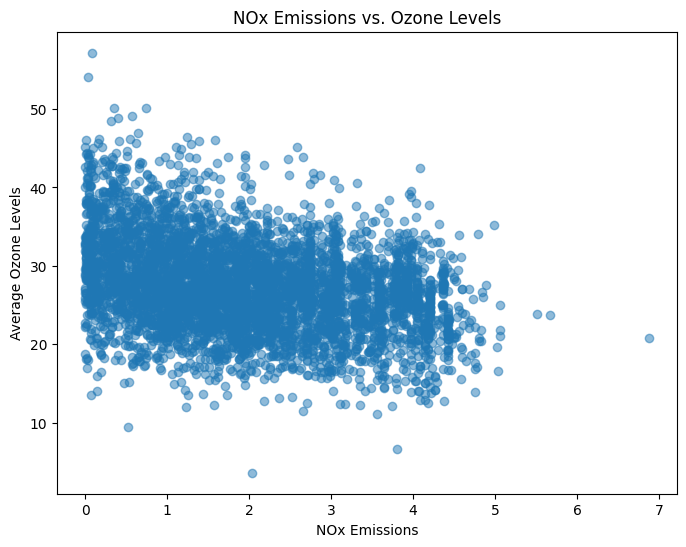

In [16]:
# Plot logarithmic NOx emissions in realtion to average ozone levels

plt.figure(figsize=(8,6))
plt.scatter(data['log_nox_emissions'], data['o3_average_values'], alpha=0.5)
plt.xlabel('NOx Emissions')
plt.ylabel('Average Ozone Levels')
plt.title('NOx Emissions vs. Ozone Levels')
plt.show()

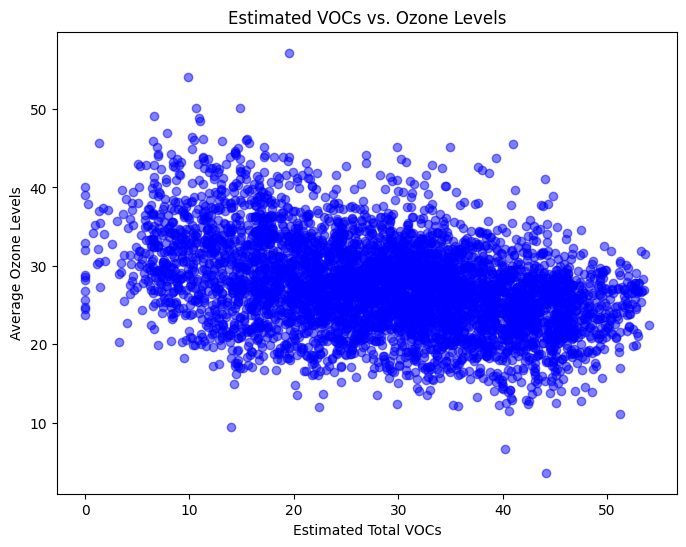

In [17]:
# Plot VOCs emissions in realtion to average ozone levels

plt.figure(figsize=(8,6))
plt.scatter(data['estimated_total_vocs'], data['o3_average_values'], alpha=0.5, color='blue')
plt.xlabel('Estimated Total VOCs')
plt.ylabel('Average Ozone Levels')
plt.title('Estimated VOCs vs. Ozone Levels')
plt.show()

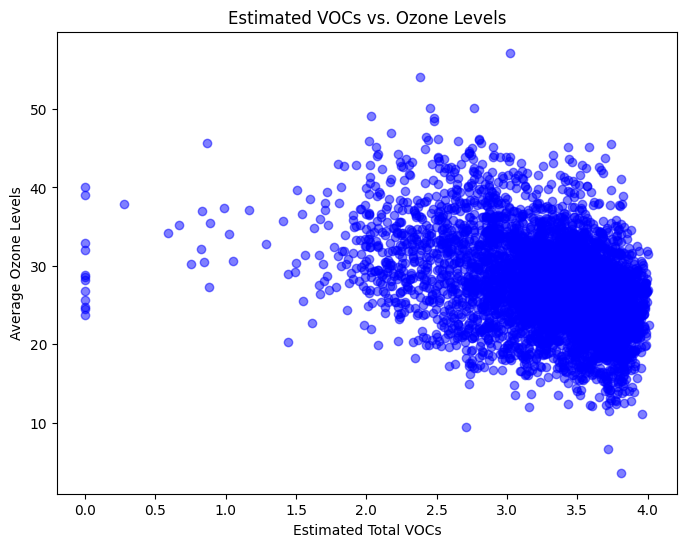

In [18]:
# Plot logarithmic VOCs emissions in realtion to average ozone levels

plt.figure(figsize=(8,6))
plt.scatter(data['log_estimated_voc_emissions'], data['o3_average_values'], alpha=0.5, color='blue')
plt.xlabel('Estimated Total VOCs')
plt.ylabel('Average Ozone Levels')
plt.title('Estimated VOCs vs. Ozone Levels')
plt.show()

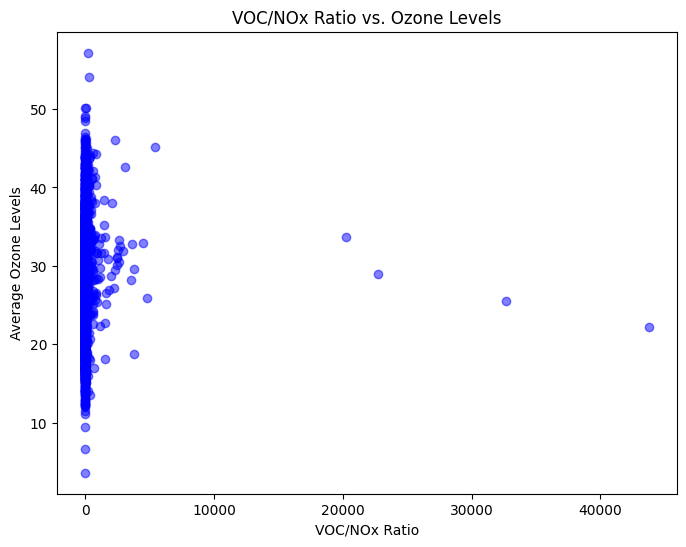

In [19]:
# Plot the VOCs/NOx ration in realtion to average ozone levels

plt.figure(figsize=(8,6))
plt.scatter(data['voc_nox_ratio'], data['o3_average_values'], alpha=0.5, color='blue')
plt.xlabel('VOC/NOx Ratio')
plt.ylabel('Average Ozone Levels')
plt.title('VOC/NOx Ratio vs. Ozone Levels')
plt.show()

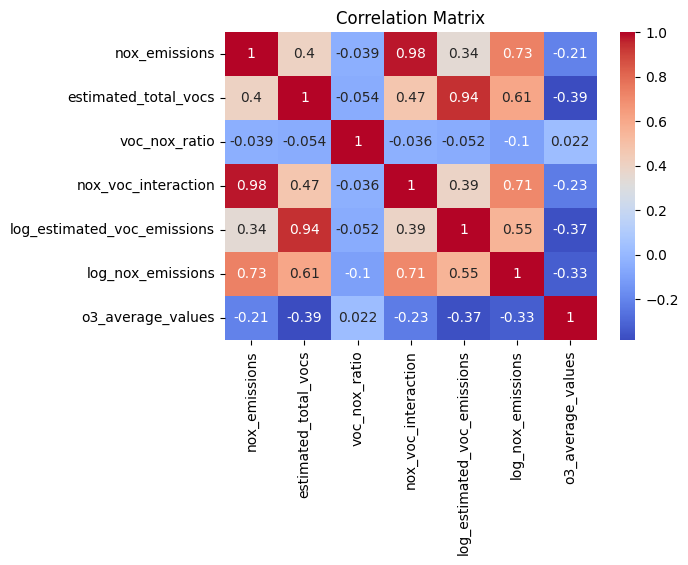

In [20]:
# Craete correlation matrix for the analysis of VOCs, NOx metrics and average ozone levels

features_of_interest = [
    'nox_emissions', 'estimated_total_vocs', 'voc_nox_ratio',
    'nox_voc_interaction', 'log_estimated_voc_emissions', 'log_nox_emissions', 'o3_average_values'
]

corr_matrix = data[features_of_interest].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('/kaggle/working/corr_vocs_nox.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Capture if either one or both of the VOCs, NOx values are relativly high

nox_threshold = data['nox_emissions'].quantile(0.75)  
voc_threshold = data['estimated_total_vocs'].quantile(0.75)

data['only_high_nox'] = ((data['nox_emissions'] > nox_threshold) & (data['estimated_total_vocs'] < voc_threshold)).astype(int)
data['only_high_voc'] = ((data['nox_emissions'] < nox_threshold) & (data['estimated_total_vocs'] > voc_threshold)).astype(int)

data['high_nox_and_voc'] = data['only_high_nox'] & data['only_high_voc']

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self.tol = tol
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7986e3237ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._nam

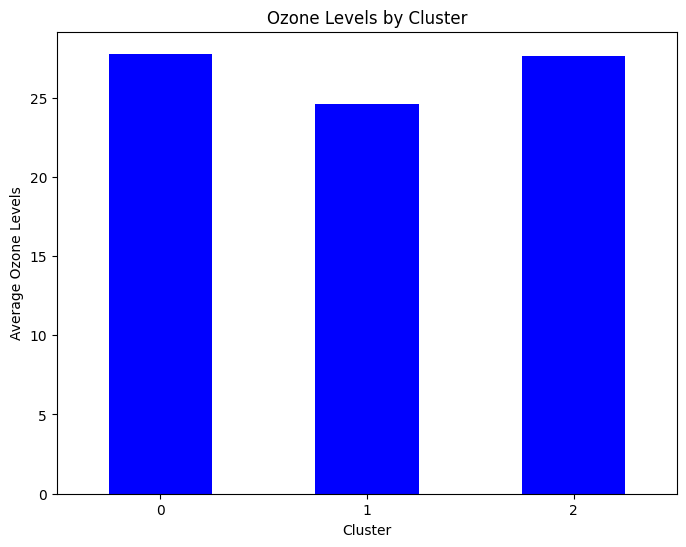

In [22]:
# k means clustring for NOx, VOCs features

clustering_features = ['nox_emissions', 'estimated_total_vocs', 'voc_nox_ratio', 'nox_voc_interaction']
X_clustering = data[clustering_features]

kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(X_clustering)

cluster_ozone_means = data.groupby('cluster')['o3_average_values'].mean()

plt.figure(figsize=(8,6))
cluster_ozone_means.plot(kind='bar', color='blue')
plt.xlabel('Cluster')
plt.ylabel('Average Ozone Levels')
plt.title('Ozone Levels by Cluster')
plt.xticks(rotation=0)
plt.show()

In [23]:
# Data preprocessing

columns_binary = ['cluster', 'only_high_nox', 'only_high_voc', 'high_nox_and_voc']

def handle_continous_data(data):
    data_continous = data.drop(columns=columns_cyclical, axis=1)
    data_continous = data_continous.drop(columns=columns_categorical, axis=1)
    data_continous = data_continous.drop(columns=columns_help, axis=1)
    data_continous = data_continous.drop(columns=columns_binary, axis=1)

    std_scaler = StandardScaler()
    data_standardized = pd.DataFrame(std_scaler.fit_transform(data_continous), columns=data_continous.columns)

    data_standardized = pd.concat([data_standardized, data[columns_cyclical]], axis=1)
    data_standardized = pd.concat([data_standardized, data[columns_categorical]], axis=1)
    data_standardized = pd.concat([data_standardized, data[columns_help]], axis=1)
    data_standardized = pd.concat([data_standardized, data[columns_binary]], axis=1)

    return data_standardized

def handle_cyclical_data(data):
    lon_values = data[columns_cyclical].squeeze()

    sin_values = np.sin(np.pi * (lon_values / 180))
    cos_values = np.cos(np.pi * (lon_values / 180))

    data['lon-sin'] = sin_values
    data['lon-cos'] = cos_values
    
    return data.drop(columns=columns_cyclical, axis=1)


def handle_categorical_data(data):
    data_categorical = data[columns_categorical]

    data_categorical = pd.get_dummies(data_categorical, columns=columns_categorical).astype(int)

    return pd.concat([data.drop(columns=columns_categorical, axis=1), data_categorical],axis=1)

def process(data):
    data = handle_continous_data(data)
    data = handle_cyclical_data(data)
    data = handle_categorical_data(data)
    
    return data

data = process(data)

In [24]:
# Split data into training, validation and test sets and remove helper columns

columns_help=['id', 'dataset']
columns_target=['o3_average_values', 'o3_daytime_avg', 'o3_nighttime_avg', 'o3_median', 'o3_perc25', 'o3_perc75', 'o3_perc90', 'o3_perc98', 'o3_dma8eu', 'o3_avgdma8epax', 'o3_drmdmax1h', 'o3_w90', 'o3_aot40', 'o3_nvgt070', 'o3_nvgt100']

def split(data):
    data_train = data[data['dataset'] == 'train']
    data_val = data[data['dataset'] == 'val']
    data_test = data[data['dataset'] == 'test']
    
    data_train = data_train.drop(columns=columns_help, axis=1)
    data_val = data_val.drop(columns=columns_help, axis=1)
    data_test = data_test.drop(columns=columns_help, axis=1)

    X_test = data_test.drop(columns=columns_target, axis=1)
    X_val = data_val.drop(columns=columns_target, axis=1)
    X_train = data_train.drop(columns=columns_target, axis=1)

    y_train = data_train[columns_target]
    y_val = data_val[columns_target]
    y_test = data_test[columns_target]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split(data)

In [25]:
# Selected target value:

target_index = 0

In [26]:
# Performace Evaluation

def calcR2(model, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_val)
    pred_test = model.predict(X_test)
    
    if pred_train.ndim == 2:
        pred_train = pred_train.ravel()
        pred_valid = pred_valid.ravel()
        pred_test = pred_test.ravel()
    
    print('Train R2 = ', r2_score(y_train, pred_train))
    print('Valid R2 = ', r2_score(y_val, pred_valid))
    print('Test R2 = ',  r2_score(y_test, pred_test))
    
def calcIQRError(model, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_val)
    pred_test = model.predict(X_test)
    
    if pred_train.ndim == 2:
        pred_train = pred_train.ravel()
        pred_valid = pred_valid.ravel()
        pred_test = pred_test.ravel()
    
    iqr_train = np.percentile(y_train, 75) - np.percentile(y_train, 25)
    iqr_val = np.percentile(y_val, 75) - np.percentile(y_val, 25)
    iqr_test = np.percentile(y_test, 75) - np.percentile(y_test, 25)
    
    iqr_train = iqr_train if iqr_train != 0 else 1e-6
    iqr_val = iqr_val if iqr_val != 0 else 1e-6
    iqr_test = iqr_test if iqr_test != 0 else 1e-6
    
    scaled_error_train = (1 / len(y_train)) * np.sum(np.abs(pred_train - y_train) / iqr_train) * 100
    scaled_error_valid = (1 / len(y_val)) * np.sum(np.abs(pred_valid - y_val) / iqr_val) * 100
    scaled_error_test = (1 / len(y_test)) * np.sum(np.abs(pred_test - y_test) / iqr_test) * 100
    
    print(f'Train Scaled Error (IQR) = {scaled_error_train:.2f}%')
    print(f'Validation Scaled Error (IQR) = {scaled_error_valid:.2f}%')
    print(f'Test Scaled Error (IQR) = {scaled_error_test:.2f}%')

In [27]:
# Benchmark Model - Linear Regression

def model(X_train, y_train, X_val, y_val, X_test, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    calcR2(lr, 'lr', X_train, X_val, X_test, y_train, y_val, y_test)
    calcIQRError(lr,  'lr', X_train, X_val, X_test, y_train, y_val, y_test)
    
model(X_train, y_train.iloc[:,target_index], X_val, y_val.iloc[:,target_index], X_test, y_test.iloc[:,target_index])

Train R2 =  0.6850561131599839
Valid R2 =  0.6069715533466283
Test R2 =  0.5323364021669816
Train Scaled Error (IQR) = 33.82%
Validation Scaled Error (IQR) = 39.91%
Test Scaled Error (IQR) = 40.02%


In [28]:
# Improved Benchmark Model - Ridge Regression

def model(X_train, y_train, X_val, y_val, X_test, y_test):
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    calcR2(ridge,'ridge', X_train, X_val, X_test, y_train, y_val, y_test)
    calcIQRError(ridge, 'ridge', X_train, X_val, X_test, y_train, y_val, y_test)
    
model(X_train, y_train.iloc[:,target_index], X_val, y_val.iloc[:,target_index], X_test, y_test.iloc[:,target_index])

Train R2 =  0.6825056792775166
Valid R2 =  0.6157966034743159
Test R2 =  0.5417342817347156
Train Scaled Error (IQR) = 34.09%
Validation Scaled Error (IQR) = 39.62%
Test Scaled Error (IQR) = 39.73%


In [29]:
# Improved Benchmark Model - Lasso Regression

def model(X_train, y_train, X_val, y_val, X_test, y_test):
    lasso = Lasso(alpha=0.0005)
    lasso.fit(X_train, y_train)

    calcR2(lasso, 'lasso', X_train, X_val, X_test, y_train, y_val, y_test)
    calcIQRError(lasso, 'lasso', X_train, X_val, X_test, y_train, y_val, y_test)
    
model(X_train, y_train.iloc[:,target_index], X_val, y_val.iloc[:,target_index], X_test, y_test.iloc[:,target_index])

Train R2 =  0.6755138234116728
Valid R2 =  0.6092504334352391
Test R2 =  0.5460634382318911
Train Scaled Error (IQR) = 34.47%
Validation Scaled Error (IQR) = 40.13%
Test Scaled Error (IQR) = 39.49%


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+00, tolerance: 2.966e-01
  elif len(alphas) > 1:


In [30]:
# Improved Benchmark Model - Elastic Net Regression

def model(X_train, y_train, X_val, y_val, X_test, y_test):
    el = ElasticNet(alpha=0.01, l1_ratio=0.6)
    el.fit(X_train, y_train)

    calcR2(el, 'el', X_train, X_val, X_test, y_train, y_val, y_test)
    calcIQRError(el,'el', X_train, X_val, X_test, y_train, y_val, y_test)
    
model(X_train, y_train.iloc[:,target_index], X_val, y_val.iloc[:,target_index], X_test, y_test.iloc[:,target_index])

Train R2 =  0.6190460498270536
Valid R2 =  0.595703550300406
Test R2 =  0.5271042420295445
Train Scaled Error (IQR) = 36.98%
Validation Scaled Error (IQR) = 41.11%
Test Scaled Error (IQR) = 40.39%


In [31]:
# This class is used to plot the history of the R² value

class R2History(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs=None):
        self.r2_train = []
        self.r2_val = []

    def on_epoch_end(self, epoch, logs=None):
        X_train, y_train = self.validation_data[0], self.validation_data[1]
        X_val, y_val = self.validation_data[2], self.validation_data[3]

        y_train_pred = self.model.predict(X_train, verbose=0)
        y_val_pred = self.model.predict(X_val, verbose=0)

        r2_train = r2_score(y_train, y_train_pred)
        r2_val = r2_score(y_val, y_val_pred)

        self.r2_train.append(r2_train)
        self.r2_val.append(r2_val)

In [32]:
# Check if GPU is activated?

if tf.test.gpu_device_name():
    print("GPU activated:", tf.test.gpu_device_name())
else:
    print("GPU not activated")

GPU not activated


In [ ]:
# Neural Network

def r2_keras(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    nn = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(20, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
        Dense(1, activation='linear')
    ])
    
    nn.summary()

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

    nn.compile(optimizer=optimizer, loss='mse', metrics=[r2_keras])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    r2_history = R2History(validation_data=(X_train, y_train, X_valid, y_valid))
    
    print("..fitting")
    nn.fit(
        X_train, y_train,
        batch_size=32, epochs=400,
        validation_data=(X_valid, y_valid),
        verbose=0,
        callbacks=[early_stopping, r2_history]
    )
    print("Done!")
    
    return nn, r2_history

nn, r2_history = model(X_train, y_train.iloc[:,target_index], X_val, y_val.iloc[:,target_index], X_test, y_test.iloc[:,target_index])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041 (23.60 KB)

 Trainable params: 6,041 (23.60 KB)

 Non-trainable params: 0 (0.00 B)

..fitting


In [ ]:
# Evalute Neural Network performance

calcR2(nn, 'nn', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])
calcIQRError(nn, 'nn', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(r2_history.r2_train, label='Training R²')
plt.plot(r2_history.r2_val, label='Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training and Validation R²')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# deprecated

# Neural Network - Bayesian Serach

def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def build_model(hp):
    nn = Sequential([
        Input(shape=(X_train.shape[1],)),
        
        Dense(
            units=hp.Int('units_layer1', min_value=8, max_value=64, step=8),
            activation='relu',
            kernel_regularizer=regularizers.l2(hp.Float('l2_layer1', min_value=0.001, max_value=0.01, step=0.001))
        ),
        Dropout(hp.Float('dropout_rate_layer1', min_value=0.0, max_value=0.5, step=0.1)),
        
        Dense(
            units=hp.Int('units_layer2', min_value=4, max_value=32, step=4),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp.Float('l2_layer2', min_value=0.001, max_value=0.01, step=0.001))
        ),
        
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))

    nn.compile(optimizer=optimizer, loss='mse', metrics=[r2_keras])
    return nn

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='bayesian_search',
    project_name='keras_tuner_example'
)

tuner.search_space_summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# tuner.search(
  #  X_train, y_train,
  #  validation_data=(X_val, y_val),
   # epochs=100,
   # callbacks=[early_stopping],
   # verbose=0
#)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Neural Network - Grid Search

def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def create_model(learning_rate=0.001, neurons_layer1=40, neurons_layer2=20, dropout_rate=0.2, l2_reg=0.001):
    nn = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(neurons_layer1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg)),
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    nn.compile(optimizer=optimizer, loss='mse', metrics=[r2_keras])
    
    return nn

model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'model__learning_rate': [0.001, 0.005, 0.01],
    'model__neurons_layer1': [20, 40, 60],
    'model__neurons_layer2': [10, 20, 30],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__l2_reg': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [400],
}

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

grid_result = grid.fit(X_train, y_train.iloc[:, target_index], validation_data=(X_val, y_val.iloc[:, target_index]), callbacks=[early_stopping])

In [ ]:
# Evalute Neural Network - Grid Search performace

calcR2(grid_result, 'gridnn', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])
calcIQRError(grid_result, 'gridnn', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(r2_history.r2_train, label='Training R²')
plt.plot(r2_history.r2_val, label='Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training and Validation R²')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Random Forest

def model_rf(X_train, y_train, X_valid, y_valid, X_test, y_test):

    rf = RandomForestRegressor(
        n_estimators=100,   
        max_depth=20,
        random_state=42,            
        n_jobs=-1,
        bootstrap=True,
    )
    
    print("..fitting")
    rf.fit(X_train, y_train)
    print("Done!")
    
    return rf

rf = model_rf(X_train, y_train.iloc[:, target_index], X_val, y_val.iloc[:, target_index], X_test, y_test.iloc[:, target_index])

In [ ]:
# Evaluate Random Forest performance

calcR2(rf, 'rf', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])
calcIQRError(rf, 'rf', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])

In [ ]:
# Gradient Boosting Machine

def model_gb(X_train, y_train, X_valid, y_valid, X_test, y_test):
    gb = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,     
        random_state=42
    )
    
    print("..fitting")
    gb.fit(X_train, y_train)
    print("Done!")
    
    return gb

gb = model_gb(X_train, y_train.iloc[:, target_index], X_val, y_val.iloc[:, target_index], X_test, y_test.iloc[:, target_index])

In [ ]:
# Evalute Gradient Boosting Machine perfomance

calcR2(gb, 'gb', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])
calcIQRError(gb, 'gb', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])

In [ ]:
# Gradient Boosting Machine - GridSearch

def model_gb_grid_search(X_train, y_train, X_valid, y_valid, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200],      
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [5, 7],        
        'subsample': [0.8, 1.0],
        'max_features': [1.0, 'log2']
    }
    
    gb = GradientBoostingRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=1, verbose=0, scoring='r2')
    
    print("..fitting GridSearchCV")
    grid_search.fit(X_train, y_train)
    print("Done!")
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation R² score: {grid_search.best_score_}")
    
    return best_model

gb_gird = model_gb_grid_search(X_train, y_train.iloc[:, target_index], X_val, y_val.iloc[:, target_index], X_test, y_test.iloc[:, target_index])

In [ ]:
# Evalaute Gradient Boosting Machine - Grid Search perfomance

calcR2(gb_gird, 'gridgb', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])
calcIQRError(gb_gird,'gridgb', X_train, X_val, X_test, y_train.iloc[:,target_index], y_val.iloc[:,target_index], y_test.iloc[:,target_index])

In [ ]:
# deprecated

# Evalaute Gradient Boosting Machine - Bayesian Search

def model_gb_bayesian_search(X_train, y_train, X_valid, y_valid, X_test, y_test):
    param_space = {
        'n_estimators': (50, 100, 200),            
        'learning_rate': (0.01, 0.1, 'log-uniform'),
        'max_depth': (3, 5, 10),             
        'subsample': (0.6, 0.8, 1.0),            
        'max_features': (0.5, 1.0)    
    }
    
    gb = GradientBoostingRegressor(random_state=42)
    
    # bayes_search = BayesSearchCV(
    #    estimator=gb,
    #    search_spaces=param_space,
    #    n_iter=30,
    #    cv=5,               
    #    n_jobs=-1,          
    #    verbose=0,          
    #    scoring='r2',
    #    random_state=42
    #)
    
    print("..fitting Bayesian SearchCV")
    # bayes_search.fit(X_train, y_train)
    print("Done!")
    
    print(f"Best parameters found: {bayes_search.best_params_}")
    print(f"Best cross-validation R² score: {bayes_search.best_score_}")
    
    return best_model

# gb_bayesian = model_gb_bayesian_search(X_train, y_train.iloc[:, target_index], X_val, y_val.iloc[:, target_index], X_test, y_test.iloc[:, target_index])